# Lab 7: Twitter data analysis  

In this lab, we will learn how to read JSON files and how to perform exploratory analysis of twitter data. As an extra credit, you will learn how to use API to download tweets on the topic of your choice.

Let us start by importing the needed packages.

In [34]:
import json
import random
import time
import calendar
import codecs
import datetime
import sys
import gzip
import string
import glob
import os
import numpy as np
import dateutil.parser

## Module 0: Reading Tweets

Tweets are saved in the form of a JSON file. Open `onetweet` file in a text editor and study how it looks. This file contains information from a single tweet. The file is written in the JSON format, which is easy for a computer to read and parse. 

**Question 1**. Google `JSON` and try to learn about this particular data format. Explain in one or two paragraphs what you learned.

Let us read `onetweet` JSON file. We will create an object and print it.

**Answer 1**: Json is a way for computers to store and exchange data. It is very similar to a dictionary or hashmap data structure. It has key-value pairs. A key is like an address, in which it is unique and maps to one or multiple values. It is a language-independent file or text format that was originally derived from the JavaScript programming language. 

In [35]:
from pprint import pprint
# tweet = json.load(open('onetweet', 'rb').decode('utf8'))
with open('onetweet.json') as f:
    tweet = json.load(f)
pprint(tweet)

{'_id': '264230205529411585',
 'contributors': None,
 'coordinates': {'coordinates': [-73.95639896, 40.71411847], 'type': 'Point'},
 'created_at': '2012-11-02T04:59:24',
 'disaster': '2012_sandy_hurricane_en',
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [{'display_url': 'instagr.am/p/Rg70o6xlkY/',
                        'expanded_url': 'http://instagr.am/p/Rg70o6xlkY/',
                        'indices': [33, 53],
                        'url': 'http://t.co/G0LdsQAz'}],
              'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'geo': {'coordinates': [40.71411847, -73.95639896], 'type': 'Point'},
 'id': '264230205529411585',
 'id_str': '264230205529411585',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': {'attributes': {},
           'bounding_box': {'coordinat

As we can see, each tweet is stored in a dictionary. Although there are more than 20 different keys in the dictionary, we introduce the most important fields which will be used in the rest of this lab.
<ul>
<li>'_id': shows the unique id of this tweet.</li>

<li>'coordinates': shows the location from which the tweet was posted. The field might be null if the tweet contains no location data, or it could contain bounding box information, place information, or GPS coordinates in the form of (longitude, latitude). </li>

<li>'created_at': shows the time the tweet has been created.</li>

<li>'text': shows the text of the tweet.</li>

<li>'user': contains multiple dictionaries describing the user, including the name of this user, the number of followers, the number of friends...</li>
</ul>

**Question 2**. Explain 3 more keys that you find interesting

3 more keys that I find interesting are: disaster, the description key inside the user's object and possibly_sensitive.

The disaster key is near at the top of the JSON object. The key basically explains what kind of natural disaster happens that is related to the tweet. I was really surprised to see this key because disaster seems to be a very specific information that shows up as a key in a Twitter JSON object. Most keys in this JSON object are for general information such as username, coordinates or text.

The description key that is inside of the user's object contains the user's profile description, which I thought pretty cool. 

The possibly_sensitive key let users know whether a tweet is offensive or sensitive. Its value is a boolean. I think it is very interesting because we can use this information from Twitter to help us in analyzing how sensitive or offensive tweets are. 

In the following code we will load around 4,000 tweets sent from New York City region during Sandy Hurricane from a JSON file `myNYC.json`. As part of this process, we will extract each tweet's post time and create a time series of the number of tweets in each hour during the event.

In [36]:
filePath='smallNYC.json'
localTweetList = []
globalTweetCounter = 0
frequencyMap = {}
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    
    # Try to extract the time of the tweet
    currentTime=dateutil.parser.parse(tweetObj['created_at'])
    currentTime = currentTime.replace(second=0)
    currentTime = currentTime.replace(minute=0)

    # print(currentTime)
    # Increment tweet count
    globalTweetCounter += 1
    
    # If our frequency map already has this time, use it, otherwise add
    if currentTime in frequencyMap.keys():
        timeMap = frequencyMap[currentTime]
        timeMap["count"] += 1
        timeMap["list"].append(tweetObj)
    else:
        frequencyMap[currentTime] = {"count":1, "list":[tweetObj]}

# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

#timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
timeIntervalStep = datetime.timedelta(hours=1)
while ( thisTime <= lastTime ):
    if ( thisTime not in frequencyMap.keys() ):
        frequencyMap[thisTime] = {"count":0, "list":[]}
        
    thisTime = thisTime + timeIntervalStep

print ("Processed Tweet Count:", globalTweetCounter)

Processed Tweet Count: 4295


## Module 1: Simple Frequency Analysis

In this section, we will cover a few simple analysis techniques for EDA of the available twitter data.

- Twitter Timeline
- Top Twitter Users
- Twitter API
- Posting Frequency Distribution
- Popular Hashtags
- Simple Event Detection
- Language Distributions

### Twitter Timeline 

To build a timeline of Twitter usage, we can simply plot the number of tweets posted per hour.

Time Frame: 2012-10-22 05:00:00 2012-11-02 04:00:00


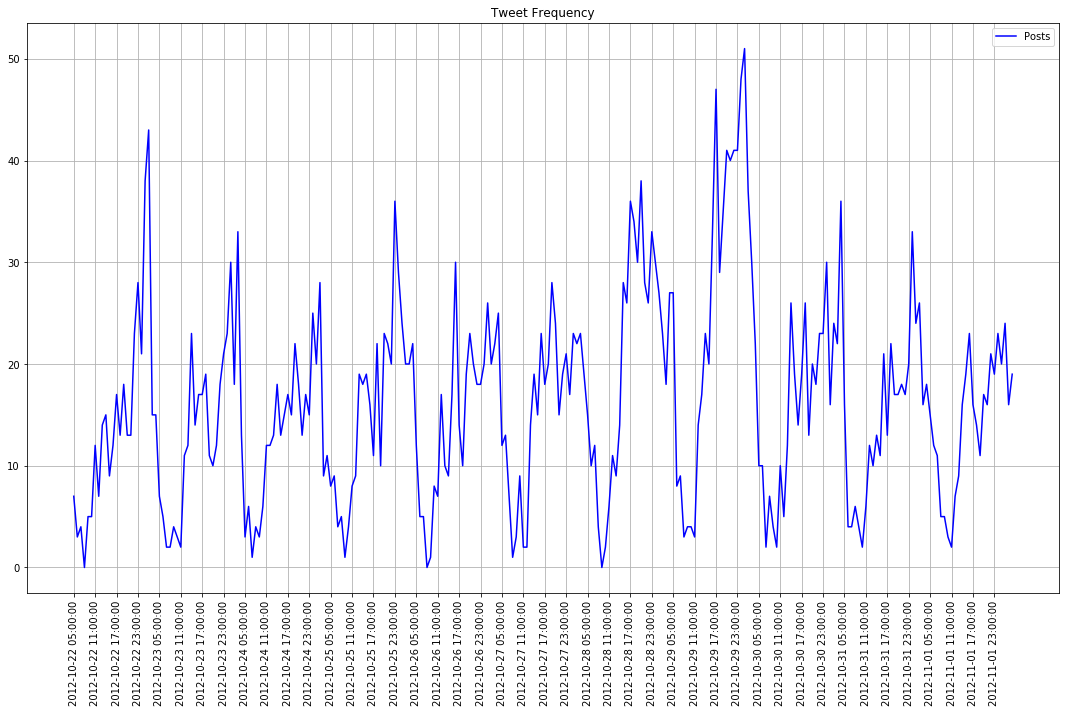

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print ("Time Frame:", sortedTimes[0], sortedTimes[-1])

# Get a count of tweets per minute
postFreqList = [frequencyMap[x]["count"] for x in sortedTimes]

# We'll have ticks every thirty minutes (much more clutters the graph)
smallerXTicks = range(0, len(sortedTimes), 6)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(frequencyMap)), [x if x > 0 else 0 for x in postFreqList], color="blue", label="Posts")
ax.grid(b=True, which=u'major')
ax.legend()

plt.show()

**Question 3**. When is the tweeting activity the largest? Find a wikipedia article about the Sandy Hurricane to understand the timeline of events surrounding it. Discuss if you see a correlation with the tweet frequencies. Select some tweets from different time points and see if the messages are correlated with the events on the ground.

The top 3 peaks for tweeting activity are: 2012-10-23 02:00:00, 2012-10-29 23:00:00 and 2012-10-30 03:00:00.

According to a Wikipeadia article on Sandy Hurricane, on the morning of 10/23/2012, we got a tropical storm warning in the area of Jamaica. This is probably when it escalted from a Watch to a Warning. This happens just a date after a hurrican watch was put out. This might helps explained why there was a spike in tweeting activity at 2012-10-23 02:00:00.

On the morning of 10/29/2012, the Tropical Storm Warning was discontinued for all region. I was surprised to see a tweet surge at 2012-10-29 23:00:00 since the tropical has been signaled to end. Maybe people were happy about the fact that it was gone. 

The highest spike was at 2012-10-30 03:00:00, which follows shortly after 2012-10-29 23:00:00, it could be that more news reached new people and maybe the same people that tweeted the night before kept on tweeting. 

### Top Twitter Users

The following piece of code reveals the users that produced the most tweets. 

In [38]:
# Create maps for holding counts and tweets for each user
globalUserCounter = {}
globalUserMap = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        
        if user not in globalUserCounter:
            globalUserCounter[user] = 1
            globalUserMap[user] = [tweet]
        else:
            globalUserCounter[user] += 1
            globalUserMap[user].append(tweet)

print ("Unique Users:", len(globalUserCounter.keys()))

Unique Users: 3042


In [39]:
sortedUsers = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)
print ("Top Ten Most Prolific Users:")
for u in sortedUsers[:10]:
    print (u, globalUserCounter[u], "\n\t", "Random Tweet:", globalUserMap[u][0]["text"], "\n----------")

Top Ten Most Prolific Users:
Young_Boss718 37 
	 Random Tweet: That random text  I had got be for LMFAO shit was funny 
----------
frankieciv608 15 
	 Random Tweet: “@JohnKincade Dear Donald Trump,
Americans &amp; Republicans chose to not involve you in this election between Prez &amp; Romney.
Please go away.” 
----------
Cocky_Johnny 15 
	 Random Tweet: @_tinaDeex3 LMAO #Dead 
----------
labroides 14 
	 Random Tweet: @SharkDevocean best of luck. That's awesome 
----------
ReelTalker 12 
	 Random Tweet: @FilmFatale_NYC also, in other news, i totally thought it was idris who tweeted me. Saw the pic and got  excited :-) 
----------
Amooniac 11 
	 Random Tweet: Je Hyper nul en Francais mais je sais qu'on ne dit pas le PLUS piire ! SEIGNEUR aidez moi a comprendre ce qui n'a pas marché ak @mhathe911 
----------
kcastrox3 11 
	 Random Tweet: Cuz this love is a sure thing. 
----------
carolsommers727 11 
	 Random Tweet: @coreymach lookin spiffy 👌 
----------
_LizmaryA 11 
	 Random Tweet: Hey 

**Question 4**. Find and print the top 10 users with the most friends. Find and print the top 10 users with the most followers. 

In [40]:
# top 10 users with the most friends

# testing out how to get friend count for a single user
print(globalUserMap["frankieciv608"][-1]["user"]["friends_count"])
print(globalUserMap["frankieciv608"][-1]["user"]["followers_count"])

# Create maps to hold number of friends
friendCounter = {}
followerCounter = {}

# loop through each user_name
# Iterate through the time stamps
for unique_user in globalUserCounter.keys():
    # since a user's tweet is ordered from oldest to newest, (refer to how globalUserMap is created)
    # each tweet contains a user object that has the friends_count
    # so we will look for the newest user object, which happens to be the last one in the list
    friends_count = globalUserMap[unique_user][-1]["user"]["friends_count"]
    friendCounter[unique_user] = friends_count
    
    # same but for counting followers
    followers_count = globalUserMap[unique_user][-1]["user"]["followers_count"]
    followerCounter[unique_user] = followers_count
    
# sort and print out top 10 users with the most friends
top_10_friends = sorted(friendCounter, key=friendCounter.get, reverse=True)[:10]
print("Top 10 users with the most friends", top_10_friends)

print("")
# sort and print out top 10 users with the most followers
top_10_followers = sorted(followerCounter, key=followerCounter.get, reverse=True)[:10]
print("Top 10 users with the most followers", top_10_followers)

731
520
Top 10 users with the most friends ['mstupenengo', 'GinsburgJobs', 'WeAreJocelyn', 'MrThugZilla2K15', 'davesurber', '55_althani', 'EddieJMontanez', 'andrewcotto', 'MargaretMolloy', 'tupaclivesss']

Top 10 users with the most followers ['mstupenengo', 'iJokes_', 'felixsalmon', 'EmersonOverton', 'umakhouny', 'AgramyQ8', '55_althani', 'QueensMuseum', 'JosephWakile', 'Majovargas_']


### Distribution of Postings

It appears a few users were posting to Twitter a lot. But how often did most Twitter users tweet during this time? We can build a histogram to see this distribution.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


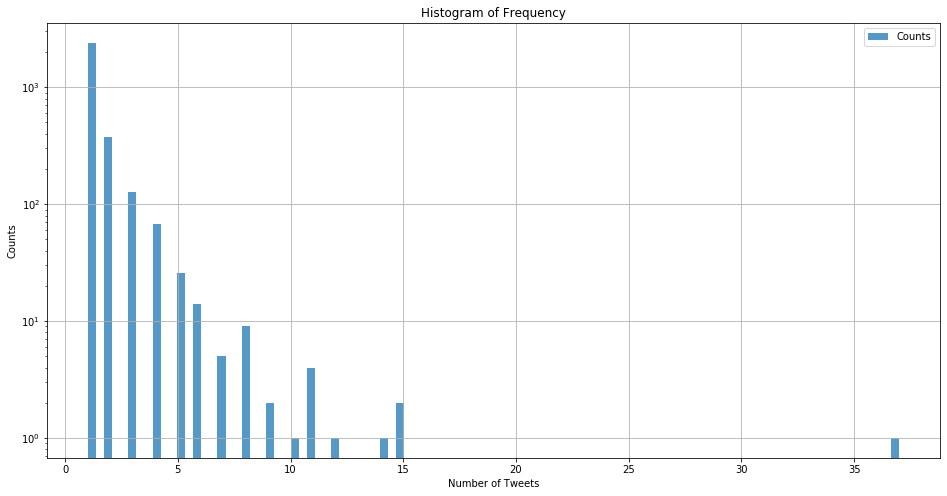

In [41]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.hist(
    [globalUserCounter[x] for x in globalUserCounter], 
    bins=100, 
    normed=0, 
    alpha=0.75,
    label="Counts",
    log=True)

plt.xlabel('Number of Tweets')
plt.ylabel('Counts')
plt.title("Histogram of Frequency")
plt.grid(True)
plt.legend()

plt.show()

**Question 5**. Study 3 users with the most posts. What were they tweeting about?



In [42]:
# find users with the most posts
for u in sortedUsers[:3]:
    print ("\nUser: ", u, globalUserCounter[u], "\n\t")
    print("Tweets:")
    for i in range(len(globalUserMap[u])):
        print(globalUserMap[u][i]["text"], "\n----------")


User:  Young_Boss718 37 
	
Tweets:
That random text  I had got be for LMFAO shit was funny 
----------
@MeerGotGame don't try and find shit lol 
----------
U inbox her on fb or text her 
----------
That wax museum is a fool in New York shit be real af 
----------
I kinda just felt when she just said idgaf lol 
----------
We be on the loud shit
Y'all be smoking that low volume 
----------
@BossBitchShxt chill out Monae you know I fucks with fab lol 
----------
I got my list tho 🙈🙉🙊 
----------
@The_Good_Fella9 it's ok 
----------
@NOFcks_Givn gave that head to ? 
----------
PART2 
----------
@The_Good_Fella9 word she's cool af 
----------
i wonder who had crush on me on twitter 😜😝😛😵 
----------
White girls don't have butts LMFAO 
----------
@BricksFromPluto lol 
----------
@SugarCocaine_ well I heard mad down south ppl say it that's why I ask 
----------
Getting alil sleepy 
----------
Moms gone for the whole night shit just about to smoke &amp; kick it with da homies 
----------
@Liya

The code above was modified from one of the given pieces of code to print out the top 3 users with the most tweets along with each user's tweets.

For user Young_Boss718 (with 37 tweets), most of this user's tweets contains a lot of profanity and inappropriate comments on very different topics. This users mostly tweet about things that occur in his/her daily life and his/her opinions on very random, dis-connected topics that cannot be categorize into groups.

For user frankieciv608 (with 15 tweets), most of this user's tweets are about political topics. He/she twets about things that happen in the news, in the national political landscape and some of the tweets are replies to political opinions. The rest of the tweets are disparate and random. 

For user CockY_Johnny (with 15 tweets), most of this user's tweets are incredibly graphic and they are about sexual topics/opinions. The rest of this user's tweets are about food or mom or grandmother. 

### Average Number of Posts

In [43]:
avgPostCount = np.mean([globalUserCounter[x] for x in globalUserCounter])
print("Average Number of Posts:", avgPostCount)

Average Number of Posts: 1.4119000657462195


### Popular Hashtags

Hashtags give us a quick way to view the conversation and see what people are discussing. Getting the most popular hashtags is just as easy as getting the most prolific users.


In [44]:
# A map for hashtag counts
hashtagCounter = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
            else:
                hashtagCounter[hashtagString] += 1

print ("Unique Hashtags:", len(hashtagCounter.keys()))
sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
print ("Top Twenty Hashtags:")
for ht in sortedHashtags[:20]:
    print ("\t", "#" + ht, hashtagCounter[ht])

Unique Hashtags: 997
Top Twenty Hashtags:
	 #sandy 108
	 #nyc 47
	 #hurricanesandy 26
	 #newyork 12
	 #brooklyn 9
	 #halloween 8
	 #instagood 8
	 #photooftheday 8
	 #frankenstorm 8
	 #hurricane 8
	 #centralpark 7
	 #debates 6
	 #instamood 6
	 #satstudytime 6
	 #igers 5
	 #picoftheday 5
	 #instagramhub 5
	 #instadaily 5
	 #oomf 5
	 #newyorkcity 5


### Event Detection w/ Keyword Frequency

Twitter is good for breaking news. When an impactful event occurs, we often see a spike on Twitter of the usage of a related keyword. Some examples are below.


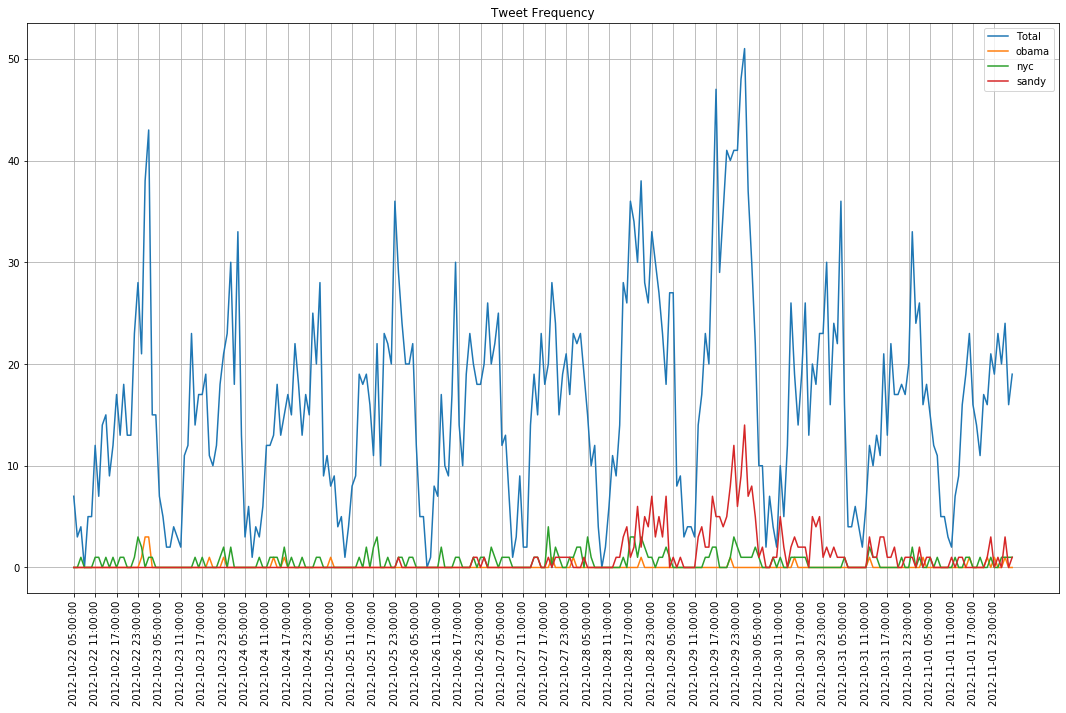

In [45]:
# What keywords are we interested in?
targetKeywords = ["obama", "nyc"]
# targetKeywords.append("lowery")
# targetKeywords.append("reilly")
targetKeywords.append("sandy")

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if keyword in tweetString:
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

ax.plot(range(len(frequencyMap)), totalCount, label="Total")


for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

**Question 6**. Study some example codes with 2 different hashtags. Explain how are those messages different. 

**Question 7**. Which among the top 20 hashtags are related to Sandy. What are the most popular non-Sandy hashtags? 

**Answer 6:**

The example code that tally how frequent a hastag is used is composed of 2 for-loops. The first for-loop goes through the sorted time array called sortedTimes. The second for-loop goes through each tweet that is associated with a particular time ticker. Then for each tweet, we extract all the unique hashtags. If a hashtag has not been saved to our dictionary, then we create a new key-value pair in which the value is 1, which is the first time we are seeing that hashtag. If a hashtag is already saved, then we increment 1, which means we see that hashtag again. 

**Answer 7:**

4 out of the top 20 hashtags are related to Sandy. 

The most popular non-Sandy hashtags are nyc, newyork, brooklyn and other topics. 

### Language Distribution

The following code gives an insight into the languages used for the tweets in your data.


In [46]:
# A map for counting each language
languageCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        lang = tweet["lang"]
        
        if lang not in languageCounter:
            languageCounter[lang] = 1
        else:
            languageCounter[lang] += 1
            
languages = sorted(languageCounter.keys(), key=languageCounter.get, reverse=True)

for l in languages:
    print(l, languageCounter[l])

en 3688
es 192
und 162
tl 29
fr 27
pt 24
ar 20
ht 20
tr 20
ru 18
it 16
in 16
de 6
ja 6
nl 6
sv 5
ko 4
fi 4
pl 4
lv 3
ro 3
hi 3
is 2
da 2
cs 2
cy 2
vi 2
et 2
sl 2
zh 1
hu 1
fa 1
lt 1
eu 1


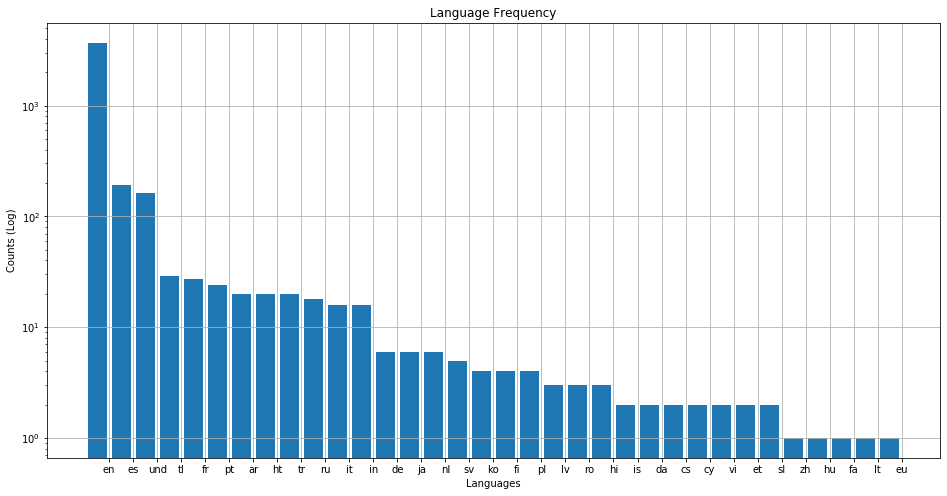

In [47]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.bar(
    np.arange(len(languages)),
    [languageCounter[x] for x in languages],
    log=True)

plt.xticks(np.arange(len(languages)) + 0.5, languages)
plt.xlabel('Languages')
plt.ylabel('Counts (Log)')
plt.title("Language Frequency")
plt.grid(True)

plt.show()

**Quesiton 8**. Now that you have experience in extracting different types of information from twitter data, perform your own EDA. Produce a 1-page report providing some interesting insights about the Sandy twitter data.

### Users' location distributions

In [48]:
# A map for counting each user's place
userPlacecounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        userPlace = tweet["user"]["location"]
        
        if userPlace not in userPlacecounter:
            userPlacecounter[userPlace] = 1
        else:
            userPlacecounter[userPlace] += 1
            
userPlaces = sorted(userPlacecounter.keys(), key=userPlacecounter.get, reverse=True)

for uP in userPlaces:
    print(uP, userPlacecounter[uP])

 841
New York, NY 192
New York 162
NYC 151
New York City 120
Brooklyn, NY 95
New Jersey 53
NJ 45
Brooklyn 38
New York  34
New York, New York 31
NY 25
Brooklyn, New York 24
 ⠀⠀⠀⠀      Hidden Leaf 23
nyc 22
Staten Island, NY 22
Queens, NY 21
New York, USA 21
Bronx, NY 19
Los Angeles, CA 15
Manhattan, NY 15
ATLANTA VIA NYC  15
near the ocean 14
 ⠀⠀⠀⠀      Hokage 14
Jersey 13
new jersey 13
New York City, NY 12
Newark, NJ 11
Staten Island 11
New Jersey, USA 11
Where I am meant to be. 11
New Jersey  10
new york 10
London 10
Jersey City 9
Boston, MA 9
K I N G S B R I D G E 9
Staten Island, New York 9
Manhattan 9
(NYC) 9
Brooklyn NY 8
Nakano 8
Astoria, NY 8
Heaven 8
poppin 8
NYC and dc 8
Morristown, NJ 7
United States 7
New York City  7
New York, New York  7
Nj 7
Jersey City, NJ 7
San Francisco, CA 7
Hoboken, NJ 7
☁️/NY 7
tuscaloosa 7
NJ/NY ✈✈ 6
ÜT: 40.6313246,-73.9454602 6
XO 6
DR & Jerseeeeeeey ❤️ 6
Camaçari, Brasil 6
Nueva York, USA 6
brooklyn  6
jersey 6
The Bronx 6
new york city 6
JERSEY 

$OUTHWARD 1
NYC; Astoria, NY; Stamford, CT 1
Carmel, NY 1
Dubai, United Arab Emirates 1
Medford, MA 1
BK! Home of Biggie and Jay! 1
Rome - Modica  1
40.743423, -73.996338 1
Iowa City, IA, USA 1
Tel Aviv 1
Nottingham, UK 1
NJ & NYC 1
NEWYORK/NEWYORK 1
gambrills. bmore. worldwide. 1
Bucktown Brooklyn, USA 1
Athens, GA 1
Nutley, NJ 1
40.788367,-73.940007 1
Queens, NY  1
everywhere 1
brooklyn, ny 1
Zanarkand 1
Venice Beach, CA 1
28.55278600,-81.27552600 1
PDX/NY/LA/CHI 1
Hackensack, NJ 1
Florida bred, NYC born/raised 1
Magic City 1
kcc cuny,Brooklyn 1
U.O.E.N.O 1
LA | NYC | BOS 1
New York/Nicaragua/Miami Beach 1
Charlotte, NC 1
Yonkers/ New Ro Raised/ NYC 1
W. Hollywood 1
iPhone: 51.815563,-9.874407 1
Staten Island, New York City 1
music 1
Yes, New York. Where else? 1
NOLA 1
Mississauga, ON 1
Queens,NYC 1
Jersey via California 1
Maywood New Jersey 1
Chill Town, N.J. 1
20 // NJ 1
İstanbul ~ Basel 1
East Orange, NJ 1
Buffalo / Troy 1
4535 47th St Woodside, NY  1
Indiana  1
Braziil! 1
Sydney 

New York | 1
Canberra, Australia 1
Di planet yang bernama Bumi 1
BDO 1
bklyn 1
Nu jerzy  1
Bushwick, Brooklyn, NY, USA 1
Chicago 1
⚖  1
Uptown Hartford 1
iPhone: 40.698730,-73.919235 1
NYC, Pittsburgh, Worldwide 1
New York. 1
Santa Monica, CA 1
NY on my way to Paris... 1
Tenerife, IC, España 1
Hoboken NJ - the 07030 1
Centrala , IL 1
JEPARA 1
New York, NY (Astoria) 1
Roosevelt, NY 1
CHI --- NYC 1
london 1
New York City, United States 1
 USA 1
Seattle & Bedstuy 1
nashville 1
N 40°41' 0'' / W 73°59' 0'' 1
A Christian in New York City 1
40.764605,-74.149191 1
iPhone: 41.041775,-71.909828 1
NYC - INTL 1
Paris/New York 1
Brooklyn (Owes The Charmer) 1
Wherever my laptop is. 1
Ny, New York 1
Boston. MA 1
New York & San Francisco 1
The Bronx, New York  1
abel's bed 1
♡ Rutgers University ♡ 1
SVP Digital @epixhd in NYC 1
908 1
Essex County, NJ  1
ֿNew York 1
 Instagram- Marsh_nets11 1
from nyc to nj 1
Ridgefield Park, NJ 1
ÜT: 40.76521,-73.980456 1
California, San Jose 1
Bronx ny 1
The Internet

In [50]:
# A map for counting each user's retweet
retweetCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        retweet = tweet["retweet_count"]
        user = tweet["user"]["screen_name"]
        
        if user not in retweetCounter:
            retweetCounter[user] = retweet
        else:
            retweetCounter[user] += retweet
            
retweets = sorted(retweetCounter.keys(), key=retweetCounter.get, reverse=True)

for rt in retweets:
    print(rt, retweetCounter[rt])

iJokes_ 54
55_althani 48
EatFellowHumans 21
Young_Boss718 10
ReplikArsivi 10
innycru 10
Simply_Pariss 9
felixsalmon 9
fuckxarthur 6
Amooniac 6
IzabellaJunq 5
CJThomasRimi85 5
_Mr_Vargas 5
_LizmaryA 5
laynaBrady 5
erica_connolly 5
RiahTheWanted 4
Clarknt67 4
TimaaaThooo 4
StevenRojas 4
Cocky_Johnny 4
QueensMuseum 4
NuevoUrbanista 4
petedykstra 4
inosente13 4
RichHartell 4
JuanMaBenitez 4
skrap2343 4
__Chelseaaaaaaa 4
kbierce 3
StarlinqA 3
davidnjesus 3
iamandasaavedra 3
Villard_51 3
ChewySeminario 3
TORnado_ 3
emsss_xo 3
stephdiannaxo 3
Marley_9 3
stfuindy 3
5thandJane 3
LariiMarie_x3 3
salutedbad 3
imsoeleet 3
DJJUANYTO 3
im_madeof_wax 3
omg_itsclyde 3
AntPulido 3
LiLfizh 3
livelaughingman 3
chinatheperson 3
tonybgoode 3
johndeguzman 3
Scorpio_Queen72 2
enhozezoh 2
Bookum_ 2
pandemona 2
IWhitt_neesNews 2
kittyashleyyy 2
truee_beauttyy 2
shannonkaylaa 2
culturaapple 2
MrThugZilla2K15 2
Certifiedbyyme 2
yooitskaitycruz 2
kcastrox3 2
Mikecostaaa 2
etherealprey 2
ChvrlieOMO 2
_BesoMiCulo_ 

nanoserwich 0
NorRocwell 0
Ave__Maria 0
LaurenAshleys 0
nxfxcom 0
bthomas208 0
JayTS_193 0
mbussey 0
JohnBon345 0
daanvanrossum 0
lynnbermudaa 0
brinapls 0
HAlnabet 0
J_hova120 0
ElijahRTaylor 0
lucysilb 0
porteousean 0
newtown_creek 0
MAN___NY 0
synthee 0
cleanolife01 0
FrankTheTank91 0
LuisERosario 0
AnthonyConio 0
adampdouglas 0
ThereAreGiants 0
pbumpnet 0
greggtilston 0
sayonical 0
NRMstyles 0
kasim_SoMe 0
PackyStache 0
maxwyeth 0
AnnaLatorre_NP 0
mattaningram 0
PRicanTaz 0
luckyboy2007 0
RespectMySexxy 0
AlexaHiluu 0
jmmantel 0
FrankFay 0
deoliveira_rich 0
MaxwellSeard 0
Aventura_Chic 0
ThckrThanASnckr 0
ssbot 0
drewjoma 0
iamrobertely 0
JohnAFerrara 0
abycats 0
youngarthur2 0
JayUrena 0
djraay 0
klcurti3 0
MikeyJevo 0
josiemacri 0
jonmarkgo 0
chaunce_de_leon 0
bogeybando 0
evanxamazing 0
darceyhowardNYC 0
MsDyaniCarissa 0
Baris 0
Sauced_Down 0
AcostaBogus99 0
gynjasnap 0
Mdls012 0
illmatic_TJ 0
Misababeii91 0
Aaron___Jones1 0
AdventureofDomo 0
Photocop2011 0
samanthalopezNY 0
Bil

KevinGreene 0
sydd_x0 0
BullaMashell 0
footballerina 0
Odds_Zonn 0
amandacoppola 0
omgitsjess 0
meliastars 0
ColeRutledge 0
AustinSilv 0
greenskulls21 0
choly1990 0
AndyTweetedWhat 0
nishishi26 0
cdelpretz 0
_____DaddyJ 0
kiasthoughts 0
micahguadalupe 0
kegrant01 0
Focuschild15 0
jkaizzi 0
jess_gianellli 0
Donovan_Rebecca 0
lfresh 0
CDMani 0
vitacococafe 0
kaylajamesx 0
BrianRiolo 0
PhotosByRequest 0
kficara 0
josemunozangari 0
TONYTOKUYA 0
jojo_cohen 0
mermaid_jls 0
LoSlater 0
Trizzy_Blaad 0
catherineapples 0
mlkshG 0
Christina_Simo 0
jennasheingold 0
BrodeurHOF 0
DavidGuti97 0
Angela2828HH 0
PetarMilanZijic 0
rob_hanvy 0
lulubelleNYC 0
JosephWakile 0
nubiaortiz11 0
BryMast 0
9long3thick 0
FredRdgz 0
fredgatesdesign 0
mattconvente 0
NgawangChoney 0
marypoppings 0
nnimrodd 0
Jxxsy 0
bwilson105 0
jazzchaplain 0
WWPROMO 0
manuelcatena 0
NeelBedii 0
AnthonyFuquan79 0
biencalabro 0
bianquita9 0
sterlingraphael 0
anthonylee85 0
YoungEasthood 0
mikebarone718 0
MarkusRiva 0
honeyberk 0
Angela

Nickf4rr 0
E_Munguia6 0
y0urher0 0
HanSoulOh 0
jhuxhux 0
reubenhernandez 0
BrooKLYNBoY87 0
BigerusHeit 0
josejosecuba 0
ameriGrande 0
Chivas071Jos 0
melylovesbeauty 0
shyeeeeen 0
LGoonerHoward 0
imatamontez 0
A_Manderinn 0
areda1120 0
Jayms13 0
GetIndMechaJobs 0
jengrunwald 0
SorayaRmouti 0
nyc10016 0
megannkathleen 0
frankgiraldi 0
newyork808 0
Mellie_626 0
sailorboyj 0
DaChUcKsTeR 0
TeenaManee 0
thiagocaarvalho 0
AwwhBic 0
JillyCMcG 0
reppep 0
Eddie_Mejia 0
bridget_widget 0
JBThursday 0
ChellyUribe 0
Leeeesmarie 0
MaryamAlAli 0
RelapseSigns 0
ronntaylor 0
TheBuzzTrend 0
araindia 0
ANTDELAROSA24 0
cerbiattina85 0
Lord_Horatio 0
lisa617 0
prem97 0
celesterose29 0
emmmykay 0
IhrtPorkFat 0
_iheartmomo 0
Candigirl 0
SBBrooklynDeals 0
wh0thefxck 0
thBIKINIboy 0
ITSONLYCLEO 0
brandonbayer 0
toolsdrummer 0
GoldenChild_GC 0
mariahorozco_ 0
michellekstyles 0
thorisalaptop 0
charlesurbine 0
JumpMan_Punk 0
BriRacks 0
_Can_only_be_me 0
itsdylan7 0
MightySquid 0
ABenzion 0
ihabhegazy4 0
Tirana69 0

In [71]:
ret_fol_ratio_Counter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        followers = tweet["user"]["followers_count"]
        user = tweet["user"]["screen_name"]
        retweet = retweetCounter[user]
        
        if followers != 0:
            ratio = retweet / followers
        else:
            ratio = -1
        
        if user not in ret_fol_ratio_Counter:
            ret_fol_ratio_Counter[user] = ratio
            
retweets = sorted(ret_fol_ratio_Counter.keys(), key=ret_fol_ratio_Counter.get, reverse=True)

for rt in retweets:
    print(rt, ret_fol_ratio_Counter[rt])

ramsup34 0.1
Jamaica1971 0.08333333333333333
inosente13 0.04395604395604396
skrap2343 0.030303030303030304
djjakew 0.029411764705882353
Villard_51 0.02857142857142857
hbshakes 0.024390243902439025
juicyjissy 0.023809523809523808
_Mr_Vargas 0.022222222222222223
Marley_9 0.019867549668874173
palaric8 0.019230769230769232
BrianHackathorn 0.019230769230769232
Simply_Pariss 0.018404907975460124
xCarmel_Kissesx 0.01818181818181818
BrianzVoice 0.017241379310344827
flolau_b 0.01694915254237288
TiCaL2Tre 0.016129032258064516
Young_Boss718 0.01451378809869376
PrincessLeeshaa 0.013888888888888888
GOB_PABLITS 0.013513513513513514
My_Fucking_Lif3 0.012658227848101266
iReignSkyyHigh 0.012658227848101266
winters07002 0.011494252873563218
fuckxarthur 0.00966183574879227
emmmaleee 0.009259259259259259
T_Hill18 0.00909090909090909
ImAtRisk 0.00909090909090909
DanielleModnaya 0.009009009009009009
JakeRust 0.008928571428571428
colemasi 0.008547008547008548
TORnado_ 0.008547008547008548
LouieLee_Pow 0.008


TunezNJ 0.0
daniellewebstah 0.0
PatHeintz 0.0
AnOaklandSir 0.0
Jossiex3 0.0
jreyes10131991 0.0
AVALANCHE_PALM 0.0
quentinbelarbi 0.0
OnlyForKindle 0.0
KateLynnClaire 0.0
mavraganis 0.0
bobbyc94 0.0
AlexandraOstrow 0.0
DaGirlNxDoor 0.0
edenbrower 0.0
HizkiaBela 0.0
Noso_o 0.0
amandarose_m 0.0
urchininc 0.0
KrystennnIV 0.0
LoveUMiiGuell 0.0
LBL4Life1 0.0
iParcee 0.0
rexroadt 0.0
jamalsocaboy 0.0
Lobomundo 0.0
YoungSpanish143 0.0
KelseyLynn1031 0.0
MishelleA_ 0.0
MRQBG_QU 0.0
djmark316 0.0
future_mediator 0.0
dingobingo_ 0.0
BinxsterWinks 0.0
StevenRojas 0.0
PatrikLandstrom 0.0
brilldelamerced 0.0
jonvox 0.0
_xoalexandria 0.0
yiannis_n 0.0
Mr_Rivs15 0.0
tatouche178317 0.0
andrewcotto 0.0
Kaimandante 0.0
RobertDeNegro 0.0
djkatch 0.0
Emmaaaaaax3 0.0
tresfraisnajee 0.0
nchakmakian 0.0
AprilKimmel 0.0
Mabe18T 0.0
BossYjustCuz 0.0
LOSO_PACINO 0.0
BlackIllusion 0.0
ilyssabeth 0.0
OhItzFlawlesz 0.0
rosalinams 0.0
ontherise_five5 0.0
bellow 0.0
sowutfarah 0.0
ppe324 0.0
RafaelDiazNYC 0.0
_WorldT

jermalwatson 0.0
DanPerz 0.0
Black96swan 0.0
_keighty 0.0
violettfem 0.0
kellymdooley 0.0
FranckLompart 0.0
amanda_catale 0.0
GinaEnriquez 0.0
ellajadia 0.0
BobbyCaputo 0.0
brian_tracey 0.0
JayStein3 0.0
MetsGnome56 0.0
estherabinowitz 0.0
UWS_manhattan 0.0
djeloy 0.0
nycmarcopolo 0.0
ShahadTB 0.0
alisveris_cini 0.0
tailorsgirl 0.0
Formula1gyrl 0.0
IAMV_DUB 0.0
Rishy_Fishy 0.0
MattSekellick 0.0
Andrew_Brooklyn 0.0
ExtremeXMA 0.0
johnjannuzzi 0.0
FlyNerd 0.0
bcolom 0.0
EthanTheVegan 0.0
J4ck_Hunt3r 0.0
NPatrickStepp 0.0
henrytcasey 0.0
Dave_Gold 0.0
hillard23 0.0
nanaheartzu 0.0
hannahlikesyouu 0.0
CiciJames 0.0
JFlorkiewicz 0.0
Paul_Iac 0.0
NYCgirlEm_1D 0.0
___MARVINNN 0.0
NickFrost_ 0.0
_sosweetMiMi 0.0
janekcbentz 0.0
petemall 0.0
danyOOHboy 0.0
SavorySweetLive 0.0
KimPoss1bL3 0.0
screamradius 0.0
DiXvii 0.0
darlenaxzgruble 0.0
im_madeof_wax 0.0
moments1D2010 0.0
kcimc 0.0
wandaflrs 0.0
KiiddPhenom 0.0
AbiWarrenG 0.0
jrnnynrlson 0.0
GermMartinez 0.0
marylizcasey 0.0
basedkitty 0.0
Se

dannypier 0.0
NAOnutrition 0.0
JuanCardonaaa 0.0
tarywllms 0.0
FireAnaa 0.0
J_uan_Jo 0.0
BryanTeixeira_ 0.0
modage 0.0
JordanLynnnnnn 0.0
_dignacio 0.0
petekachu 0.0
dramakim 0.0
Breana_20 0.0
Newshadeof_blak 0.0
__Siriaa 0.0
s84abhishek 0.0
kat_pugacheva 0.0
tennisjun 0.0
_xPhenomenal 0.0
OllieGray_ 0.0
ElLatinAssassin 0.0
Aniterekka 0.0
e_covintree 0.0
schmiddyy_ 0.0
EliaMosko 0.0
ShawnyyXO 0.0
alexguy423 0.0
ebroms 0.0
Tatijana_C 0.0
sztul 0.0
lilmissjen 0.0
DeLaConcha 0.0
jenniferism_ 0.0
itsmisscs 0.0
AO_Tone 0.0
raising_DeBARR 0.0
l_lancee 0.0
chvastajr 0.0
ChantelRenee21 0.0
_floodedlungs 0.0
lizsanchez015 0.0
Nacho_Aguayo 0.0
MarcoHafke 0.0
joshbarone 0.0
joezen777 0.0
livebeyond_26 0.0
addison9820 0.0
_KevinRC 0.0
susietech 0.0
dennisl23 0.0
Mr_Shakiira 0.0
Fran_Moreta 0.0
NYPost_Brazille 0.0
kaylaclarke511 0.0
MsAliCaldwell 0.0
Jreneee_ 0.0
SoleAmon 0.0
wyskida 0.0
pchace1 0.0
EmmaValentine5 0.0
BiggDaddieLuz 0.0
LotsAVision 0.0
SarahJenner__ 0.0
KevDNY 0.0
jbee807 0.0
ABasse

whiskeymonsey 0.0
ABenzion 0.0
ihabhegazy4 0.0
Tirana69 0.0
EBrosnan1 0.0
JamesBruni 0.0
TheOneTruePax 0.0
FintanMcHugh1 0.0
KeithKropski 0.0
petty_lord 0.0
wistrazor 0.0
MikeFriedman6 0.0
DaRealNerdd 0.0
rosaalia_maria 0.0
kieranmurphydp 0.0
BretheKid 0.0
janojmz 0.0
Lauren_Morra 0.0
Alchemista89 0.0
peter_hurley 0.0
GeoffBurleson 0.0
Jenn_Varga 0.0
XAVINY 0.0
Wanderluster_19 0.0
whereslenis 0.0
Omari_Lat 0.0
Blazetheshit 0.0
angieschmitz 0.0
_iamkingrico 0.0
TheLexIsaacs 0.0
sjelms 0.0
personalitini 0.0
nataliemjones 0.0
JayBarryx 0.0
SonjasSoul 0.0
anastasia_aless 0.0
IceDaddyMackk_ 0.0
annie_martucci 0.0
ettenyel 0.0
NickoBange 0.0
JustSayin726 0.0
irv_daddie 0.0
pdawg1986 0.0
nene_1108 0.0
andybappy 0.0
eliasvngs 0.0
TheRyanPotter 0.0
Anthony_Manza 0.0
JasonGirard 0.0
Walshthethrone 0.0
citadamn 0.0
anangyuli 0.0
diyaj 0.0
aceytoso_2 0.0
ty_speaks_619 0.0
nyccrowsgirl 0.0
wherescafr 0.0
frankhoffmans 0.0
caitlyncourtney 0.0
tamiiiiiiiiiiii 0.0
ThatNickBrady 0.0
Forevermacckin 0.0


In [53]:
# A map for counting each user's total sensitive tweet
sensitiveCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:        
        
        # I noticed that for some tweets, they have possibly_sensitive field
        # but some dont so we just going to look for those with this field
        
        if "possibly_sensitive" in tweet:
            sensitiveTweet = tweet["possibly_sensitive"]
            user = tweet["user"]["screen_name"]
        
            if user not in sensitiveCounter:
                if sensitiveTweet:
                    sensitiveCounter[user] = 1
                else:
                    sensitiveCounter[user] = 0
            else:
                if sensitiveTweet:
                    sensitiveCounter[user] += 1
                else:
                    sensitiveCounter[user] = 0
            
sensitiveTweets = sorted(sensitiveCounter.keys(), key=sensitiveCounter.get, reverse=True)

for t in sensitiveTweets:
    print(t, sensitiveCounter[t])

MrAnthonyRaul 2
MsMarshaeX 1
RespectMyCreep 1
TheKingZombie 1
Elroyjetson718 1
_____DaddyJ 1
chyeahitssam 1
Sykkkkkkkkk 1
TiCaL2Tre 1
ZhxTxt 1
KarmelaSweetz 1
whatupjames 0
Quithelastword 0
GimoNasiff 0
diqphotoholic 0
patvw13 0
JedihomerT 0
wheelyum 0
Noonz 0
MsMeleque 0
TheJeffCruz 0
enhozezoh 0
MidtownCoffee 0
MollyKeyes 0
TeshawnEdmonds 0
LotsofMartinis 0
ManifestoLo 0
YourScheid 0
CostasNY 0
jamieneutron 0
ThinkerInMotion 0
mhgoodell 0
JDRyznar 0
rustyjtrump 0
kaylacob 0
nsc1087 0
ale_arca 0
Whyvoni 0
Carnegro 0
Da_BBCofQU 0
UnnDunn 0
oye_juan 0
KerrySin 0
markatack 0
galvorniii 0
camillewho 0
DenisGorman 0
Oblachko 0
HikeNYC 0
grnj 0
MobileHealthInc 0
forktorque 0
GetPubRelatJobs 0
ambernoemusic 0
jsluk 0
Ahmed_milanesta 0
ben26NYC 0
dabnis_brickey 0
ixleah 0
RobWoods314 0
sytrader 0
straharino 0
merve_durdu 0
JoaoCRRamos 0
kriegs 0
pandemona 0
daniellagrace_ 0
BobGearing 0
Barbikat 0
SafenZhai 0
BaconSeason 0
rudyinnyc 0
JTversion1 0
etonified 0
dominicantwi 0
charlespgarcia 0
a

misjay44 0
KennyKnight 0
friskygeek 0
OhDeerDryGoods 0
mynameisnikkita 0
mikecavalier 0
mceks1 0
tokuyuki 0
KMShoots 0
meekismurder 0
FireTheCanon 0
KrystennnIV 0
rubieeliz 0
RazorsNYC 0
LeftyJeenyus 0
LizankaGG 0
HuseyinYucell 0
djd1972 0
jesskrausesmith 0
ChaseRabenn 0
janeyztnoyes 0
rezzz 0
LcintheD 0
ajlawrence 0
onedrunkboy 0
sdadich 0
SorayaShushtar 0
DoubleB_NYC 0
kraykray 0
matt_muni 0
juliotavarez 0
lownote 0
CeylanSarihan 0
Jstemps8 0
silmjim 0
TeeteeintheCity 0
MrGarrettJones 0
corellianjedi2 0
Jhoon09 0
livelaughingman 0
patrickjanelle 0
digenger 0
innycru 0
cugirl02 0
pvalverdee 0
DRE4785 0
AlexCkingdom 0
MyBestBKRealtor 0
HampsDetailing 0
ChANtiWaa 0
JovelRoystan 0
BrowBeatWillie 0
hananmusic 0
willazcona 0
MattConner 0
gnokko21 0
w_pat_tc 0
drmirror 0
JoJo_Son 0
davidgoldsen 0
ltwhale 0
catbirdnyc 0
NAOnutrition 0
J_uan_Jo 0
modage 0
petekachu 0
s84abhishek 0
tennisjun 0
e_covintree 0
schmiddyy_ 0
jhonleiderhenao 0
ebroms 0
lilmissjen 0
itsmisscs 0
chvastajr 0
ChantelRen

## Module 2: Classification

In this part of the lab, we will work on a binary classificaiton problem. In particular, we would like to see how easy it is to discriminate between tweets with hashtag #sandy and the rest of them. To do it, we will first create labels: positive tweets will be those with hashtag #sandy and negative those without the hashtag. Then, we will create a bag-of-words vector out of each tweet, but we will exclude word "#sandy". To produce the bag-of-words representation we will use the `CountVectorizer` functionality 

In [54]:
import pandas as pd
import numpy as np
import codecs, json

"""
Step 1. Create sentences and labels from json file. 
"""
filePath='smallNYC.json'
sents = []
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    sents.append(tweetObj['text'])
    
"""
Step 2.1. Get label. If sent contains '#sandy', label=1; otherwise, label=0
"""
labels = np.array(['#sandy' in sent.split() for sent in sents], dtype='int')
print(pd.Series(labels).value_counts())
"""
Step 2.2. Represent the data into Bag-of-words features, i.e, each sentence is a 
            vector of word counts. 
          a). Only select words with frequency >= 5
          b). Remove label words '#sandy'
"""

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words = ['#sandy'])
features = vectorizer.fit_transform(sents)


print('#sandy' in vectorizer.get_feature_names())
print(features.toarray())
print(vectorizer.get_feature_names())

0    4234
1      61
dtype: int64
False
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['00', '10', '100thingsaboutme', '12', '13', '14', '15', '16', '18', '20', '2012', '21', '24', '26', '28', '2nd', '30', '40', '50', '6th', 'able', 'about', 'actually', 'ads', 'adventure', 'af', 'after', 'afternoon', 'again', 'against', 'ago', 'ain', 'air', 'airport', 'al', 'album', 'alert', 'alive', 'all', 'almost', 'already', 'also', 'always', 'am', 'amazing', 'america', 'american', 'amp', 'an', 'and', 'another', 'any', 'anyone', 'anything', 'anyway', 'apartment', 'apocalypse', 'app', 'apple', 'appreciate', 'aqui', 'are', 'area', 'aren', 'around', 'art', 'as', 'ask', 'asked', 'asleep', 'ass', 'astoria', 'at', 'ave', 'avenue', 'away', 'awesome', 'awkward', 'aww', 'awww', 'babe', 'baby', 'back', 'bacon', 'bad', 'ballroom', 'bar', 'barclays', 'battery', 'be', 'beach', 'beat', 'beautiful', 'because', 'bed', 'been', 'beer', 'before',

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sandy'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


**Quesiton 9**. Given the data set of labeled tweets, you have to train a classification model and check the accuracy. Remember to first split the data into training and test. You should explore kNN classification, decision tree classification, Random Forest classification.

**Question 10**. Train the so-called *Logistic regression classifier* and check its accuracy. Compare with the results from *Question 9*. The following lines of code will be useful to do it.

**Answer 9:**

In [65]:
# split the data into training and testing

# needed to split dataset into testing and training
from sklearn.model_selection import train_test_split

# for kNN Classifier
from sklearn import neighbors

# for Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# for Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [66]:
# kNN classification
k = 5
predictor = neighbors.KNeighborsClassifier(n_neighbors = k)
predictor.fit(X_train, y_train);
kNN_accuracy = predictor.score(X_test,y_test)

print("kNN accuracy is {}".format(kNN_accuracy))

kNN accuracy is 0.9837083010085338


In [67]:
# Decision Tree
# Train
clf = DecisionTreeClassifier().fit(X_train, y_train)

y_hat = clf.predict(X_test)

# Find the Decision Tree's accuracy
accuracy = clf.score(X_test, y_test)
print("Decision Tree's accuracy: {}".format(accuracy))

Decision Tree's accuracy: 0.9728471683475562


In [68]:
# Random Forest
rf = RandomForestClassifier(n_estimators = 1000)

# Train the model on training data
rf.fit(X_train, y_train);
rf_accuracy = rf.score(X_test, y_test)

print("Random Forest's accuracy: {}".format(rf_accuracy))

Random Forest's accuracy: 0.9837083010085338


As observed, 
kNN has 98.37% accuracy.
Decision Tree has 97.28% accuracy.
Random Forest has 98.37% accuracy, which is the same as kNN with k = 5.

In [69]:
"""
Step 3. Divide data into train and test 
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42) 
import time
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression(solver='lbfgs')
start_time = time.time()
clf.fit(X_train, y_train)
print('Time for %s fitting: %.3f' % ('LogisticRegression', time.time() - start_time))
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('Test Perf ACC: %.3f, AUC: %.3f' %(accuracy, auc))

Time for LogisticRegression fitting: 0.061
Test Perf ACC: 0.989, AUC: 0.986


Logistic Regression has accuracy of 98.9%. It has the highest accuracy rate in comparison to kNN, random forest and decision tree. 